In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# preprocessing  (load, drop, encoding)

In [2]:
raw_data = pd.read_excel('drama_data.xlsx')


# Selecting features that would be used for prediction
data = raw_data.loc[:, ['방송국', '요일', '첫방영', '1화 시청률']]
#data = raw_data[['작품명', '방송국', '요일', '첫방영','1화 시청률']].copy()
data.index = raw_data['작품명']

# Parsing the years from date-data
data[['첫방영']] = [date.year for date in data['첫방영']].copy()

### Encoding (company, day of week, years)

In [394]:


# One Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore')

# Encoding Broadcasting Company
company = pd.DataFrame(ohe.fit_transform(data[['방송국']]).toarray(), 
             columns=[c.strip('_') for c in ohe.get_feature_names([''])])

# Encoding the day of week
day_of_week = pd.DataFrame(ohe.fit_transform(data[['요일']]).toarray())
dow_columns = np.array(['fri-sat', 'wed-thu', 'mon-tue', 'weekend'])
day_of_week.columns = dow_columns

# Encoding the years
years = pd.DataFrame(ohe.fit_transform(data[['첫방영']]).toarray())
years.columns = [year.strip('_') for year in ohe.get_feature_names([''])]

processed = pd.concat([company, day_of_week, years], axis=1)
processed.index = data.index
print(data['1화 시청률'])
first_rating = pd.DataFrame(data['1화 시청률'], index=data.index)
processed = pd.concat((processed, first_rating), axis=1)

작품명
(아는 건 별로 없지만) 가족입니다    3.122
외출                     3.079
반의 반                   2.449
방법                     2.492
블랙독                    3.331
                       ...  
디데이                    1.741
라스트                    1.364
사랑하는 은동아               0.965
순정에 반하다                1.227
하녀들                    1.632
Name: 1화 시청률, Length: 404, dtype: float64


# Heat map 

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:2

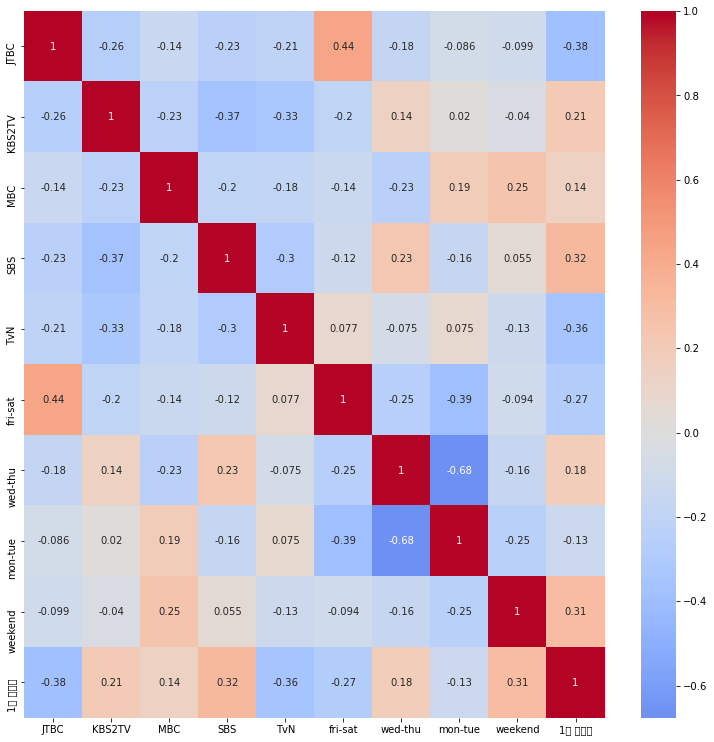

In [4]:
plt.figure(figsize=(13,13))
sns.heatmap(processed[['JTBC','KBS2TV','MBC','SBS','TvN','fri-sat',
                      'wed-thu','mon-tue','weekend','1화 시청률']].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.show()

# Why years data is needed

,mean,min,max
2010,11.609524,6.300,20.7
2011,8.825960,0.686,16.1
2012,7.526525,0.688,19.3
2013,8.077200,0.562,22.2
2014,5.848632,0.686,23.8
2015,6.065900,0.965,24.4
2016,5.944684,0.880,16.4
2017,5.707000,1.749,15.6
2018,4.878286,1.357,23.3
2019,4.599333,1.766,10.4


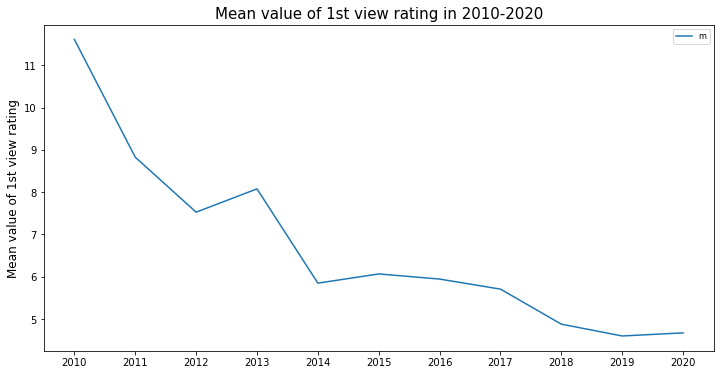

In [5]:
years_data = [str(year) for year in range(2010,2021)]
dicts = {}

for year in years_data:
    dicts[year] = processed[processed[year] == 1]['1화 시청률'].agg(['mean','min','max'])

plt.figure(figsize=(12,6))
plt.title('Mean value of 1st view rating in 2010-2020', fontsize = 15)
plt.ylabel('Mean value of 1st view rating', fontsize=12)
plt.plot(pd.DataFrame(dicts).T['mean'])
plt.legend(('mean'), fontsize = 8)
pd.DataFrame(dicts).T

# Kevin Bacon value
Let us convert data of names of actor who was on tv show into kevin bacon value. We would count it as a new feature about actors

In [275]:
bacon_data = pd.read_csv('bacon_data.csv', index_col=[0])
bacon_data

,작품명,배역,배우,순서,bacon
0,반의 반,하원,정해인,1,2.128423
1,반의 반,한서우,채수빈,2,2.063657
2,반의 반,문순호,이하나,3,2.220207
3,반의 반,강인욱,김성규,4,2.750185
4,반의 반,전은주,이상희,5,2.246484
...,...,...,...,...,...
8119,싸인,정병도,송재호,14,2.200962
8120,싸인,시가노 레이코,전익령,15,2.153220
8121,싸인,이호진,김성오,16,2.032568
8122,싸인,우재원,오현철,17,2.637306


In [257]:
# drop the drama which doesn't exist in bacon_data
# data.drop(['강구 이야기', '기적'], inplace=True )
bacon_index = set(bacon_data['작품명'].unique())

def bacon_factor(drama, num=4, alpha = 0.85):
    bacons = bacon_data[bacon_data['작품명'] == drama]['bacon'][:num]
    reverse = 10 / sum(bacons) * alpha
    sub = sum(3 - bacons)
    
    return reverse, sub

# Test

In [241]:
rev, sub = bacon_factor('영혼수선공', 4)
print('영혼수선공     rev: {}, sub: {}'.format(rev, sub))

rev, sub = bacon_factor('동백꽃 필 무렵', 4)
print('동백꽃 필 무렵  rev: {}, sub: {}'.format(rev, sub))

영혼수선공     rev: 0.9967883338396771, sub: 3.4726128793486306
동백꽃 필 무렵  rev: 1.0448093895005004, sub: 3.864544781643227


# Preprocess

In [456]:
def get_bacon_factors(alpha=0.8):
    
    bacon_factors ={}
    for drama in data.index:
        rev, sub = bacon_factor(drama, num=3, alpha=alpha)
        bacon_factors[drama] = rev
    
    return bacon_factors

def add_bacon_factor(processed, alpha=0.8):
    bacon_factors = get_bacon_factors(alpha)
    bacon_factors = pd.DataFrame(bacon_factors.values(), index=bacon_factors.keys(), columns=['Bacon factor'])
    processed2 = pd.concat((processed, bacon_factors), axis=1)
    return processed2

def rating_scailing(processed):
    df_norm = pd.DataFrame()
    df_std = pd.DataFrame()
    years_dict = {}
    for year in range(2010, 2021):
        by_year = processed[processed[str(year)]==1]['1화 시청률']
        mean = by_year.mean()
        std = by_year.std()
        stan = (by_year - mean) / std
        norm = (by_year - by_year.min()) / (by_year.max() - by_year.min())
        years_dict[year] = {'mean' : mean,
                            'std' : std,
                            'max' : by_year.max(),
                            'min' : by_year.min()}
        
        df_norm = pd.concat((df_norm, norm))
        df_std = pd.concat((df_std, stan))
    return years_dict, df_norm, df_std
        
def get_scailed(processed, scailing):
    years_dict, norm, stan = rating_scailing(processed)
    assert scailing in ['norm', 'stan'],  'norm or stan'
    if scailing == 'norm':
        scaled = pd.DataFrame(norm)
    else:
        scaled = pd.DataFrame(stan)
        
    scaled = pd.DataFrame(scaled)
    base_data = processed.drop(['1화 시청률'], axis=1)
    scaled.columns = ['1화 시청률']
    scaled = pd.concat((base_data, scaled), axis=1)
    
    return years_dict, scaled

def decode_scailed(processed, scailing, years_dict):
    df_decoded = pd.DataFrame()
    for year in range(2010,2021):
        try:
            by_years = processed[processed[str(year)] == 1]['1화 시청률']
        except:
            pass
        else:
            mean, std, max_, min_ = years_dict[year].values()
            assert scailing in ['norm', 'stan'],  'norm or stan'
            if scailing == 'norm':
                decoded = by_years * (max_ - min_) + min_
            else:
                decoded = by_years * std + mean
            df_decoded = pd.concat((pd.DataFrame(decoded), df_decoded))
    decoded = pd.concat((processed.drop(['1화 시청률'], axis=1 ), df_decoded), axis = 1)
    return decoded

def decode_scailed_test(test, scailing, years_dict):
    mean, std, max_, min_ = years_dict[year].values()
    assert scailing in ['norm', 'stan'],  'norm or stan'
    if scailing == 'norm':
        decoded = by_years * (max_ - min_) + min_
    else:
        decoded = by_years * std + mean
    return decoded

In [457]:
y,n=get_scailed(processed, 'norm')
decode_scailed_test(n['1화 시청률'][:3],'norm', y)


KeyError: '2020'

In [323]:
get_processed2(0.1)

,JTBC,KBS2TV,MBC,SBS,TvN,fri-sat,wed-thu,mon-tue,weekend,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,1화 시청률,Bacon factor
작품명,,,,,,,,,,,,,,,,,,,,,
(아는 건 별로 없지만) 가족입니다,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.122,0.153096
외출,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.079,0.166831
반의 반,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.449,0.155951
방법,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.492,0.158123
블랙독,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.331,0.165960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
디데이,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.741,0.158829
라스트,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.364,0.156438
사랑하는 은동아,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.965,0.152897


# To use Model-list
1. NN
2. Bayesian Linear Reg
3. Decision Forest Reg
4. Boosted Decision Tree Reg

In [524]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.keras import TqdmCallback
from tqdm import tqdm

def rmse(model, X_test, y_test):
    pred = model.predict(X_test).squeeze()
    targ = y_test
    rmse = np.sqrt(mean_squared_error(pred, targ))
    return rmse

def mae(model, X_test, y_test):
    pred = model.predict(X_test)
    targ = y_test
    mae = np.sqrt(mean_absolute_error(pred, targ))
    return mae

def deco_mae(model, X_test, y_test, scailing, years_dict):
    
    pred = model.predict(np.array(X_test))
    pred = pd.concat((X_test, pd.DataFrame(pred, columns=['1화 시청률'])), axis=1)
    pred = decode_scailed(pred, scailing, years_dict)['1화 시청률']
    
    targ = pd.concat((X_test, pd.DataFrame(y_test, columns=['1화 시청률'])), axis=1)
    targ = decode_scailed(targ, scailing, years_dict)['1화 시청률']
    
    
    mae = np.sqrt(mean_absolute_error(pred, targ))
    return mae

class Keep_model():
    def __init__(self):
        self.pred = 10
        self.best_ = None
    def __call__(self, model, pred):
        if pred < self.pred:
            self.pred = pred
            self.best_ = model
    def best(self):
        return self.best_, self.pred

# NN

In [399]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

tf.random.set_seed(0)

def data_split(data):
    
    X = data.loc[:, data.columns != '1화 시청률']
    y = data.loc[:, data.columns == '1화 시청률']
    X_train, X_test, y_train, y_test = (np.asarray(dataframe) for dataframe in train_test_split(X, y, test_size=0.2))
    
    return X_train, X_test, y_train, y_test
    

def nn_model(data):
    
    X_train, X_test, y_train, y_test = data_split(data)

    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(rate=0.05))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.05))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.05))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam', metrics = ['mae', 'accuracy'])
    
    return model, X_train, X_test, y_train, y_test

# Training with Base data 

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

mae : 1.4247405700880573


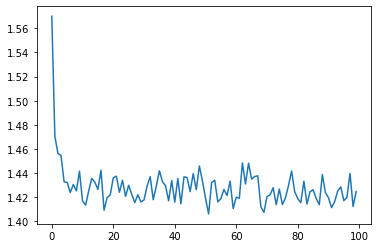

In [486]:
model, X_train, X_test, y_train, y_test = nn_model(processed)
result_list = []

for _ in tqdm(range(100)):
    model.fit(X_train, y_train, epochs=10, verbose=0)
    result = mae(model, X_test, y_test)
    result_list.append(result)

    
plt.plot(result_list)
print('mae : {}'.format(result_list[-1]))

# Training with Bacon factor

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


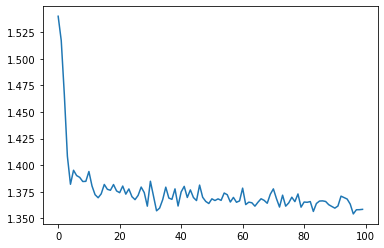

0, mae : 1.3585221263228116
Best : 1.3542246686941286


100%|██████████| 100/100 [00:37<00:00,  2.63it/s]


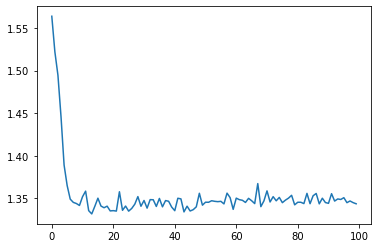

0.1, mae : 1.3435951186650488
Best : 1.3317054715632164


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


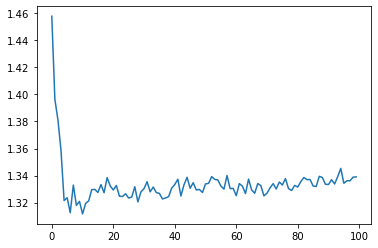

0.5, mae : 1.3389963400000806
Best : 1.3115616792508908


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


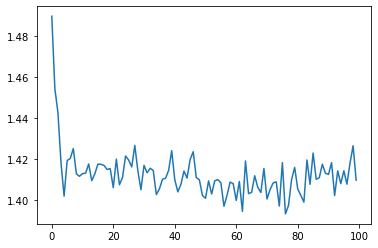

0.8, mae : 1.4095588441832743
Best : 1.393105237553888


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


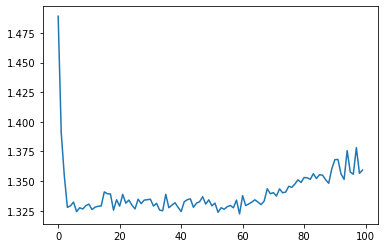

1, mae : 1.3593394548823001
Best : 1.3223070691015029


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


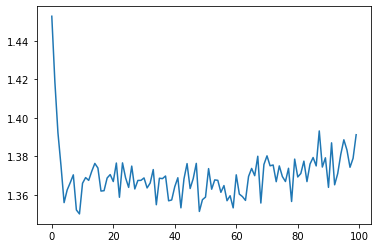

2, mae : 1.39120636163139
Best : 1.3501032532607429


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


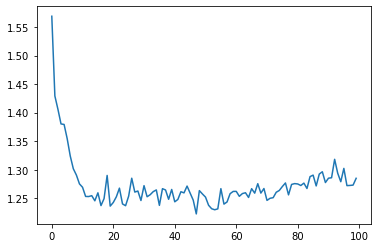

5, mae : 1.2849589785331792
Best : 1.2225942780194927


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


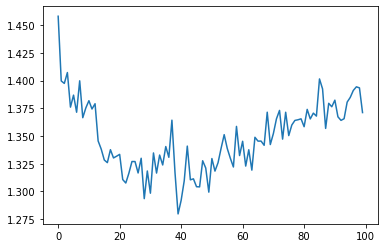

10, mae : 1.3711424115299131
Best : 1.2796243191779744


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


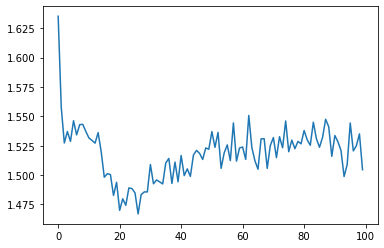

15, mae : 1.5045636113690668
Best : 1.4669583934632877


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


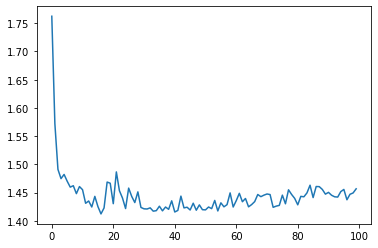

20, mae : 1.4567607281930612
Best : 1.4123242571834917


In [530]:
np.random.seed(0)

for alpha in [0, 0.1, 0.5, 0.8, 1, 2, 5, 10, 15, 20]:
    processed2 = add_bacon_factor(processed, alpha)
    model, X_train, X_test, y_train, y_test = nn_model(processed2)
    result_list = []
    model_name = 'train with bacon'
    Keep = Keep_model()

    for _ in tqdm(range(100)):
        history = model.fit(X_train, y_train, epochs=10, verbose=0)
        result = mae(model, X_test, y_test)
        result_list.append(result)
        Keep(model, result)


    plt.plot(result_list)
    plt.show()
    print('{}, mae : {}'.format(alpha,result_list[-1]))
    m, pred = Keep.best()
    print('Best : {}'.format(pred))

# Training with normalized data

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


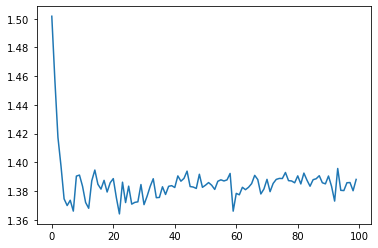

  0%|          | 0/100 [00:00<?, ?it/s]

norm, mae : 1.388163349542717
Best : 1.3641534543000118


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


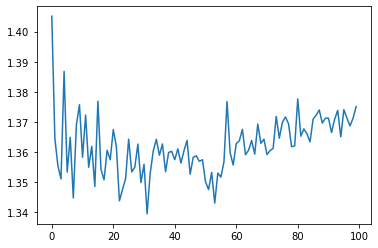

stan, mae : 1.3751106235003536
Best : 1.3394678063721799


In [529]:
for scailing in ['norm', 'stan']:
    Keep = Keep_model()
    years_dict, normalized = get_scailed(processed, scailing)
    model, X_train, X_test, y_train, y_test = nn_model(normalized)
    result_list = []

    for _ in tqdm(range(100)):
        X_test = pd.DataFrame(X_test, columns=normalized.columns[:-1])
        
        model.fit(X_train, y_train, epochs=10, verbose=0)
        result = deco_mae(model, X_test, y_test, scailing, years_dict)
        result_list.append(result)
        Keep(model, result)


    plt.plot(result_list)
    plt.show()
    print('{}, mae : {}'.format(scailing, result_list[-1]))
    m, pred = Keep.best()
    print('Best : {}'.format(pred))

# Training normalized data wiithout years

In [513]:
you = pd.read_csv('youtube_review.csv', index_col=[0]).drop(['강구 이야기', '기적'])
with_sent = pd.concat((processed,you), axis = 1)
with_sent.fillna(with_sent['sent'].min(), inplace=True)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


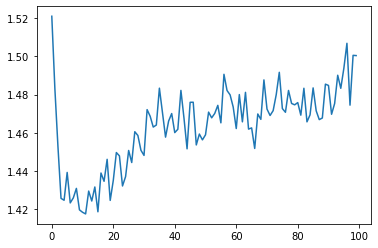

mae : 1.5004087527758472
Best : 1.4174991420172052


In [531]:
model, X_train, X_test, y_train, y_test = nn_model(with_sent)
result_list = []
Keepmodel = Keep_model()

for _ in tqdm(range(100)):
    model.fit(X_train, y_train, epochs=10, verbose=0)
    result = mae(model, X_test, y_test)
    result_list.append(result)
    Keepmodel(model, result)
    


plt.plot(result_list)
plt.show()
best_model, pred = Keepmodel.best()
print('mae : {}'.format(result_list[-1]))
print('Best : {}'.format(pred))

# Integrated data 

100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


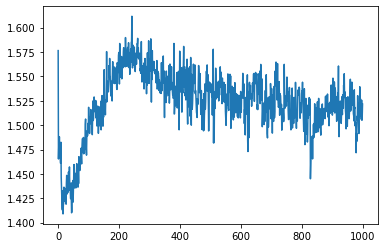

stan, mae : 1.5215787672325047
Best : 1.3299479506879595


In [535]:
with_bacon = add_bacon_factor(processed, 5)
bacon_sent = pd.concat((with_bacon, you), axis = 1)
bacon_sent.fillna(bacon_sent['sent'].min(), inplace=True)

model, X_train, X_test, y_train, y_test = nn_model(bacon_sent)
result_list = []
Keepmodel = Keep_model()

scailing = 'stan'

years_dict, normalized = get_scailed(bacon_sent, scailing)
model, X_train, X_test, y_train, y_test = nn_model(normalized)
result_list = []

for _ in tqdm(range(1000)):
    X_test = pd.DataFrame(X_test, columns=normalized.columns[:-1])

    model.fit(X_train, y_train, epochs=5, verbose=0)
    result = deco_mae(model, X_test, y_test, scailing, years_dict)
    result_list.append(result)
    Keep(model, result)


plt.plot(result_list)
plt.show()
print('{}, mae : {}'.format(scailing, result_list[-1]))
m, pred = Keep.best()
print('Best : {}'.format(pred))

In [559]:
processed

,JTBC,KBS2TV,MBC,SBS,TvN,fri-sat,wed-thu,mon-tue,weekend,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,1화 시청률
작품명,,,,,,,,,,,,,,,,,,,,,
(아는 건 별로 없지만) 가족입니다,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.122
외출,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.079
반의 반,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.449
방법,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.492
블랙독,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
디데이,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.741
라스트,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.364
사랑하는 은동아,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.965


# Karios Data!!!

In [550]:
Kairos = pd.read_excel('answer.xlsx')
Kairos = Kairos[Kairos['작품명'] == '카이로스']
ka_sent = pd.read_csv('ka_review.csv')

In [552]:
Kairos.columns

Index(['작품명', '장르', '시청률평균', '연도', '요일', '시', '분', '분량', '분할방송', '방송기간',
       '방송시작', '방송종영', '부작', '시즌', '전편', '원작', '각본', '연출', '책임프로듀서', '프로듀서',
       '편집', '촬영', '조연출', '기획', '제작자', '제작사', '음악', 'HD', 'key'],
      dtype='object')

In [572]:
K = np.array([[0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.5776259706895543*5, 0.922973]])
kai = pd.DataFrame(K, columns=X_test.columns)

In [578]:
a = m.predict(np.array(kai))
print(a[0][0])
b = years_dict[2020]
print('카이로스 예측 시청률 :',a[0][0] * b['std'] + b['mean'])

0.037720725
카이로스 예측 시청률 : 4.782165527498989


In [556]:
X_test[:2]

,JTBC,KBS2TV,MBC,SBS,TvN,fri-sat,wed-thu,mon-tue,weekend,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,Bacon factor,sent
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.605269,0.671000
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.589461,0.810137


# Random Forest  Reg

In [279]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

RFreg = RandomForestRegressor()
AdaB = AdaBoostRegressor()
Bagreg = BaggingRegressor()
Extreg = ExtraTreesRegressor()
GBoost = GradientBoostingRegressor()

params = [
    {}
]
models = {'randomforest':RFreg, 'adaboost':AdaB, 'bagging':Bagreg, 
          'extratree':Extreg, 'gboost':GBoost}


def test_model(model, data, n_splits=5):
    
    kf = KFold(n_splits)
    X = data.loc[:, data.columns != '1화 시청률']
    y = data.loc[:, data.columns == '1화 시청률']
    result = []
    for tr,ts in kf.split(X):
        
        X_train = X.iloc[tr, :]
        X_test = X.iloc[ts, :]
        y_train = y.iloc[tr, :]
        y_test = y.iloc[ts, :]
        
        model.fit(X_train, y_train.squeeze())
        result.append(mae(model, X_test, y_test.squeeze()))
    
    return result

for name ,model in models.items():
    result = test_model(model,processed)
    
    print("{}\nmean : {}, max : {}, min : {}".format(name, np.mean(result), np.max(result), np.min(result)))


randomforest
mean : 1.7356389034993633, max : 2.021833334373016, min : 1.479359616708172
adaboost
mean : 1.9051628992712046, max : 2.147741080828002, min : 1.6228515130569858
bagging
mean : 1.7674978227135099, max : 2.1246483676899484, min : 1.4986364636117744
extratree
mean : 1.7602310935881682, max : 1.9657437856832676, min : 1.569251872813672
gboost
mean : 1.7373970192448092, max : 2.0410917771239947, min : 1.4457464749558961


In [332]:
for name ,model in models.items():
    for alpha in [0, 0.1, 0.5, 0.8, 1, 2, 5, 10, 15]:
        processed2 = get_processed2(alpha)
        result = test_model(model, processed2)
        print("{}, {}\nmean : {}, max : {}, min : {}".format(alpha,name, np.mean(result), np.max(result), np.min(result)))

0, randomforest
mean : 1.729044183326513, max : 1.99541598993151, min : 1.4668357859834567
0.1, randomforest
mean : 1.738986761969637, max : 2.121278113150969, min : 1.4477925157716074
0.5, randomforest
mean : 1.7554617058174737, max : 2.153783686136253, min : 1.434969006418855
0.8, randomforest
mean : 1.745482847981973, max : 2.1003961927852246, min : 1.4469815325551174
1, randomforest
mean : 1.7394984390646215, max : 2.142738707044484, min : 1.434018268733606
2, randomforest
mean : 1.7520201664461985, max : 2.1266818834356336, min : 1.4215911360249442
5, randomforest
mean : 1.749268434556796, max : 2.114078601503107, min : 1.4528578053165204
10, randomforest
mean : 1.7637014937829594, max : 2.125112742107267, min : 1.4620106229875336
15, randomforest
mean : 1.733616684147335, max : 2.1204413848693546, min : 1.4196598155084716
0, adaboost
mean : 1.8812036906693037, max : 2.1178954530881637, min : 1.5652033550706157
0.1, adaboost
mean : 1.911430834052243, max : 2.155579124910226, min :

In [22]:
max_depth = [6,8,10,12]
n_estimators = [100,200,400]
min_samples_leaf = [3,5,7,10]
min_samples_split = [3,5,7,10]
learning_rate = [.05, .1, .2]

rfr_params = {'bootstrap': [True, False],
          'max_depth': max_depth,
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10],
          'n_estimators': n_estimators}

gb_params = {'n_estimators': n_estimators,
              'max_depth':max_depth,
              'min_samples_leaf':min_samples_leaf,
              'min_samples_split':min_samples_split,
              'learning_rate':learning_rate}



ada_params = {''}



In [488]:
randomforest = GridSearchCV(RFreg, param_grid=rfr_params, n_jobs=1)
randomforest.fit(X_train, y_train.squeeze())
mae(randomforest.best_estimator_, X_test, y_test.squeeze())

1.4388834137727897

In [489]:
gboost = GridSearchCV(GBoost, param_grid=gb_params, n_jobs=1)
gboost.fit(X_train, y_train.squeeze())
mae(gboost.best_estimator_, X_test, y_test.squeeze())

1.3989961058216283

In [100]:
open('drama_list',processed.index)

Index(['(아는 건 별로 없지만) 가족입니다', '외출', '반의 반', '방법', '블랙독', '유령을 잡아라', '위대한 쇼',
       '60일, 지정생존자', '어비스', '사이코메트리 그녀석',
       ...
       '판타스틱', '청춘시대', '마녀보감', '욱씨남정기', '마담 앙트완', '디데이', '라스트', '사랑하는 은동아',
       '순정에 반하다', '하녀들'],
      dtype='object', name='작품명', length=406)